In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import utils
from utils.train import train_FireEvacuation
from utils.vae import *
import torchvision
from torchvision import datasets, transforms
from utils.utils import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Read the data
train_data = np.load('FireEvac_train_set.npy')
test_data = np.load('FireEvac_test_set.npy')
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

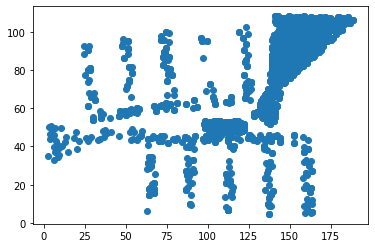

In [3]:
# Plot the training data
plt.scatter(train_data[:,0], train_data[:,1])

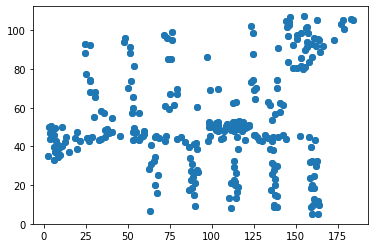

In [4]:
# Plot the Test data
plt.scatter(test_data[:,0], test_data[:,1])

In [26]:
obs_dim = 2
latent_dim = 2# Size of the latent variable z
hidden_dim = 256  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim)

In [27]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=600, shuffle=True
    )

In [28]:
# The training depends heavily on the initial conditions, might need to restart it a few times before it finds
# a good initial point for the optimization

train_FireEvacuation(vae, train_loader, test_loader, obs_dim)

Epoch 0
  loss = 15993.099609375
Epoch 1
  loss = 9689.468750000
Epoch 2
  loss = 5068.804199219
Epoch 3
  loss = 2656.633056641
Epoch 4
  loss = 1823.296020508
Epoch 5
  loss = 1493.950805664
Epoch 6
  loss = 1315.702270508
Epoch 7
  loss = 1183.497802734
Epoch 8
  loss = 1063.228149414
Epoch 9
  loss = 956.360961914
Epoch 10
  loss = 859.315002441
Epoch 11
  loss = 776.590515137
Epoch 12
  loss = 701.704589844
Epoch 13
  loss = 626.879943848
Epoch 14
  loss = 565.294067383
Epoch 15
  loss = 506.230621338
Epoch 16
  loss = 453.377197266
Epoch 17
  loss = 408.876617432
Epoch 18
  loss = 368.245635986
Epoch 19
  loss = 335.102966309
Epoch 20
  loss = 305.347045898
Epoch 21
  loss = 283.242919922
Epoch 22
  loss = 256.548889160
Epoch 23
  loss = 239.346282959
Epoch 24
  loss = 224.757812500
Epoch 25
  loss = 210.448745728
Epoch 26
  loss = 197.872512817
Epoch 27
  loss = 188.028823853
Epoch 28
  loss = 179.092849731
Epoch 29
  loss = 170.241699219
Epoch 30
  loss = 162.761260986
Epoch 31

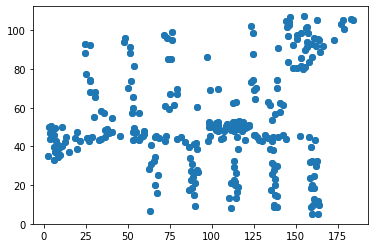

VAE reconstruction:


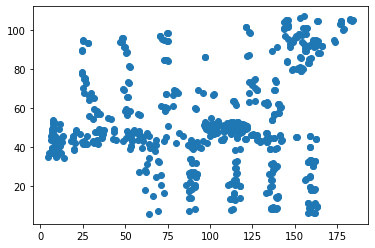

VAE samples:


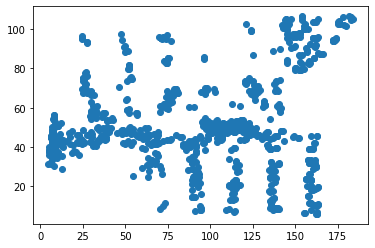

In [29]:
# View original test images
plt.scatter(test_data[:,0], test_data[:,1])
plt.show()
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
reconstruction = reconstruct_output(test_loader, vae)
plt.scatter(reconstruction[:,0], reconstruction[:,1])
plt.show()
# Sampling
print("VAE samples:")
x = sample(1000, vae)
plt.scatter(x[:,0], x[:,1])
plt.show()

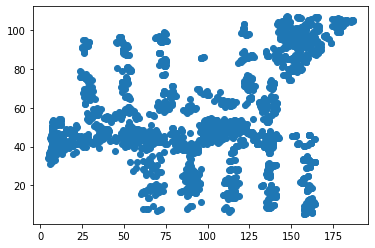

critical number!
2800


In [67]:
# Find critical number
samples = [1500, 2000, 2500,2800, 2900, 3000, 3500, 4000, 5000]
for s in samples:
    x = sample(s, vae)
    num_crit = 0
    for coord in x:
        if 130<coord[0]<150 and 50< coord[1]<70:
            num_crit += 1
    if num_crit > 100:
        plt.scatter(x[:,0], x[:,1])
        plt.show()
        print("critical number!")
        print(s)
        break

In [57]:
import json
import copy

def generate_default_pedestrian():
    """
    Generates an initialized pedestrian object to be added to the scenario json
    
    :returns: 
        return: an initialized pedestrian as a dictionary
    """
    false = False
    null = None
    return {
        "attributes": {
            "id": 8,
            "radius": 0.2,
            "densityDependentSpeed": false,
            "speedDistributionMean": 1.34,
            "speedDistributionStandardDeviation": 0.26,
            "minimumSpeed": 0.5,
            "maximumSpeed": 2.2,
            "acceleration": 2.0,
            "footstepHistorySize": 4,
            "searchRadius": 1.0,
            "walkingDirectionCalculation": "BY_TARGET_CENTER",
            "walkingDirectionSameIfAngleLessOrEqual": 45.0
        },
        "source": null,
        "targetIds": [1],
        "nextTargetListIndex": 0,
        "isCurrentTargetAnAgent": false,
        "position": {
            "x": 5.7,
            "y": 1.2
        },
        "velocity": {
            "x": 0.0,
            "y": 0.0
        },
        "freeFlowSpeed": 1.6239471913829229,
        "followers": [],
        "idAsTarget": -1,
        "isChild": false,
        "isLikelyInjured": false,
        "psychologyStatus": {
            "mostImportantStimulus": null,
            "threatMemory": {
                "allThreats": [],
                "latestThreatUnhandled": false
            },
            "selfCategory": "TARGET_ORIENTED",
            "groupMembership": "OUT_GROUP",
            "knowledgeBase": {
                "knowledge": []
            }
        },
        "groupIds": [],
        "groupSizes": [],
        "trajectory": {
            "footSteps": []
        },
        "modelPedestrianMap": null,
        "type": "PEDESTRIAN"
    }

def add_pedestrians(coords):
    path_to_scenario = "MI_Building.scenario"
    
    with open(path_to_scenario, 'r') as myfile:
            data = myfile.read()
            # parse file
            obj = json.loads(data)
            #obj["name"] = obj["name"]+"_new"

            # calculate new x and y coordinates
            new_pedestrian_coord_y = coord[1]
            new_pedestrian_coord_x = coord[0]
            new_pedestrian = generate_default_pedestrian()

            # Find already used pedestrian Ids to avoid confusions
            ids = []
            for dynamicattr in obj["scenario"]["topography"]["dynamicElements"]:
                if dynamicattr["type"] == "PEDESTRIAN":
                    ids.append(dynamicattr["attributes"]["id"])
            if len(ids) > 0:
              max_id = np.max(ids)
            else:
              max_id = 0
            # Find target id  
            targetid = obj["scenario"]["topography"]["targets"][0]["id"]
            # Set new pedestrian's target id
            new_pedestrian["targetIds"] = [targetid]
            # Set new pedestrian's id
            new_pedestrian["attributes"]["id"] = int(max_id + 1)
            # Set new pedestrian's x and y coordinates
            new_pedestrian["position"]["x"] = float(new_pedestrian_coord_x/10)
            new_pedestrian["position"]["y"] = float(new_pedestrian_coord_y/10)
            # Add pedestrian to the scenario's dictionary
            obj["scenario"]["topography"]["dynamicElements"].append(new_pedestrian)

    # Save to a new json file
    with open(path_to_scenario, 'w') as outfile:
        json.dump(obj, outfile, indent=4)



In [394]:
x = sample(100, vae)
# Add generated coordinates to scenario file
for coord in x:
    add_pedestrians(coord)